<a href="https://colab.research.google.com/github/ichinose0115/-/blob/main/%E7%8A%AC%E7%8C%AB%E5%88%A4%E6%96%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/kagglecatsanddogs_5340.zip"

In [ ]:
!ls -1  PetImages/Dog |wc -w

12501


In [ ]:
# -------------------------------------------------------------------
# 各種ライブラリのインポート
# -------------------------------------------------------------------
import os
import cv2

# -------------------------------------------------------------------
# 定数の定義
# -------------------------------------------------------------------
DATADIR = "./PetImages"
MODEL_DIR = "/content/drive/MyDrive"
CATEGORIES = ["Dog", "Cat"]
#IMG_SIZE = 50
IMG_SIZE = 150

# -------------------------------------------------------------------
# メイン処理（画像を読込み、犬猫データセットを設定）
# -------------------------------------------------------------------
#犬猫データセットを定義
training_data = []

#画像を読込み、犬猫データセットを設定
#（0:Dog、1:Cat)…class_numはCATEGORIESの配列index／categoryはCATEGORIESの中身
for class_num, category in enumerate(CATEGORIES):
    #ディレクトリを設定（ループ1回目：./PetImages/Dog　2回目：./PetImages/Cat)
    path = os.path.join(DATADIR, category)
    for image_name in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, image_name),)         # 画像読み込み
            img_resize_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # 画像のリサイズ（５０✕５０）
            training_data.append([img_resize_array, class_num])             # 画像データ(犬 or 猫)、ラベル情報(0 or 1)を追加
        except Exception as e:
            #画像の読込みエラーはスルー（スキップして次の画像へ）
            pass

学習データのラベル： 0
学習データのラベル： 1
学習データのラベル： 0
学習データのラベル： 1


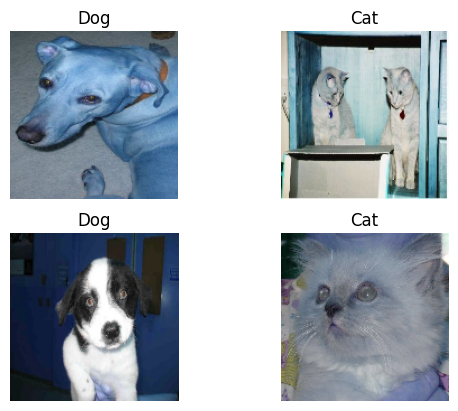

In [ ]:
import numpy as np
import random
from sklearn import model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

TRAIN_SIZE = 5000
TEST_SIZE = 500
BATCH_SIZE = 32
EPOCHS = 20

# -------------------------------------------------------------------
# 関数の定義
# -------------------------------------------------------------------
# 正規化を行う関数：Xを0～1に変換する
# 引数(X)
# 戻り値(0～1)
def normalize(x):
    x_max = np.max(x)
    x_min = np.min(x)
    return (x - x_min) / (x_max - x_min)

# -------------------------------------------------------------------
# メイン処理（画像の前加工＋モデル作成・訓練・テスト）
# -------------------------------------------------------------------
##########################
# 画像の前加工
##########################
random.shuffle(training_data)  # 犬猫データセットをシャッフル
X_train = []  # 画像データ
Y_train = []  # ラベル情報

# データセット作成
for feature, label in training_data:
    X_train.append(feature)
    Y_train.append(label)

# データセットをlist配列からNumpy配列に変換
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# データセットの確認(サンプルで４つだけ)
for i in range(0, 4):
    print("学習データのラベル：", Y_train[i])
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.title(label = 'Dog' if Y_train[i] == 0 else 'Cat')
    plt.imshow(X_train[i], cmap='gray')
plt.show()

#データセットを訓練データ(5000)とテストデータ(500)に分割
t = model_selection.train_test_split(X_train, Y_train, train_size=TRAIN_SIZE, test_size=TEST_SIZE)
train_feature, test_feature, train_label, test_label = t

#訓練データとテストデータを正規化（0～1の値に揃える）
train_feature = normalize(train_feature)
test_feature = normalize(test_feature)

##########################
# モデル作成・訓練・テスト
##########################
#モデルの定義
model = Sequential()
#入力－畳込み層－全結合層－出力(2:softmax)
#畳込み層 フィルタ（３✕３）を32枚　0パティングで入力と出力サイズが同じ　入力の形（５０✕５０✕３　最後の３はRGBの３）
model.add(layers.Conv2D(32,(3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)))
#畳込み層 フィルタ（３✕３）を32枚
model.add(layers.Conv2D(32,(3, 3), activation='relu'))
#プーリング層　Max（２✕２）
model.add(layers.MaxPool2D(pool_size=(2,2)))
#畳み込み層の追加
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
# ここから追加の畳み込み層を追加
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
# ドロップアウト層を追加
model.add(layers.Dropout(0.35))  # ドロップアウト率を調整できます（0.5は50%のユニットが無効になる設定です）
#平坦化層　1次元にする（2次元以上の入力データを1次元のデータに変換）
model.add(layers.Flatten())
#全結合層　256ユニット
model.add(layers.Dense(256, activation='relu'))
#全結合層　２ユニット(犬・猫）のsoftmax（それぞれの確率）
model.add(layers.Dense(2, activation='softmax'))

#最適化アルゴリズム、損失関数、評価関数のリスト設定
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# EarlyStoppingの設定(テストの損失値が10回連続上昇するとエポックをストップ)
early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            mode='auto',
                            patience=5
)


#モデルを学習させる（メインは訓練データ　グラフ可視化のためにテストデータを指定）
history = model.fit(train_feature, train_label, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_feature, test_label)
                    ,callbacks=[early_stopping] # CallBacksにEarlyStoppingを設定
                    )

# 学習履歴の可視化・グラフ表示（accuracy）
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 学習履歴の可視化・グラフ表示（loss）
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#モデルの損失値と評価値を返す（テストデータ）
score = model.evaluate(test_feature, test_label, verbose=2)

#テストデータの損失値と評価値をプリント
print('Test loss:', score[0])
print('Test accuracy:', score[1])